In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from shap import TreeExplainer

In [18]:
train_df = pd.read_csv('./data/df_train_preprop_clear.csv')

In [20]:
cat_features = np.load('./data/vars/categorical_columns.npy')
columns_for_drop = ['type_prepayment']

In [21]:
train_df.drop(columns_for_drop, axis=1, inplace=True)

In [22]:
cat_features = [i for i in cat_features if i not in columns_for_drop]

In [23]:
train_df[cat_features] = train_df[cat_features].astype(str)
train_df[cat_features] = train_df[cat_features].fillna('None')

In [24]:
target_var = 'item_losses'

In [26]:
y = train_df[target_var]
X = train_df.drop(target_var, axis=1)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42)

In [67]:
model_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'iterations': 500, # на 1000 циклах модель переобучается
    'loss_function': 'RMSE'
}

In [68]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

In [69]:
ctb_reg = CatBoostRegressor(**model_params)

In [70]:
ctb_reg.fit(train_pool, eval_set=val_pool, verbose=True, early_stopping_rounds=500)

0:	learn: 50.8455354	test: 52.6643870	best: 52.6643870 (0)	total: 118ms	remaining: 59.1s
1:	learn: 48.5235905	test: 50.1765482	best: 50.1765482 (1)	total: 222ms	remaining: 55.4s
2:	learn: 46.4888601	test: 47.9971402	best: 47.9971402 (2)	total: 353ms	remaining: 58.5s
3:	learn: 44.7604972	test: 46.1392553	best: 46.1392553 (3)	total: 471ms	remaining: 58.4s
4:	learn: 43.3495764	test: 44.6940004	best: 44.6940004 (4)	total: 582ms	remaining: 57.6s
5:	learn: 41.9925107	test: 43.1862706	best: 43.1862706 (5)	total: 700ms	remaining: 57.6s
6:	learn: 40.8866512	test: 41.9788489	best: 41.9788489 (6)	total: 806ms	remaining: 56.7s
7:	learn: 39.9710889	test: 40.9888350	best: 40.9888350 (7)	total: 919ms	remaining: 56.5s
8:	learn: 39.1251137	test: 40.0303176	best: 40.0303176 (8)	total: 1.03s	remaining: 56.2s
9:	learn: 38.4504598	test: 39.3056897	best: 39.3056897 (9)	total: 1.2s	remaining: 58.8s
10:	learn: 37.7965764	test: 38.5607014	best: 38.5607014 (10)	total: 1.4s	remaining: 1m 2s
11:	learn: 37.2991748

In [71]:
y_pred = ctb_reg.predict(X_val)

In [72]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error (MAE): 12.606669590092327
Mean Squared Error (MSE): 933.1359949516286
Root Mean Squared Error (RMSE): 30.547274754904546
R^2 Score: 0.6963646035899406


In [91]:
residuals = y_val - y_pred

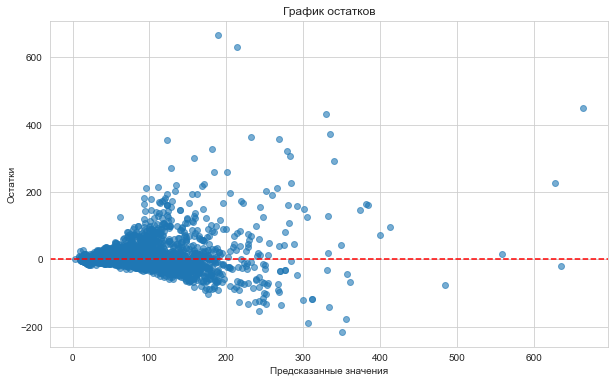

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

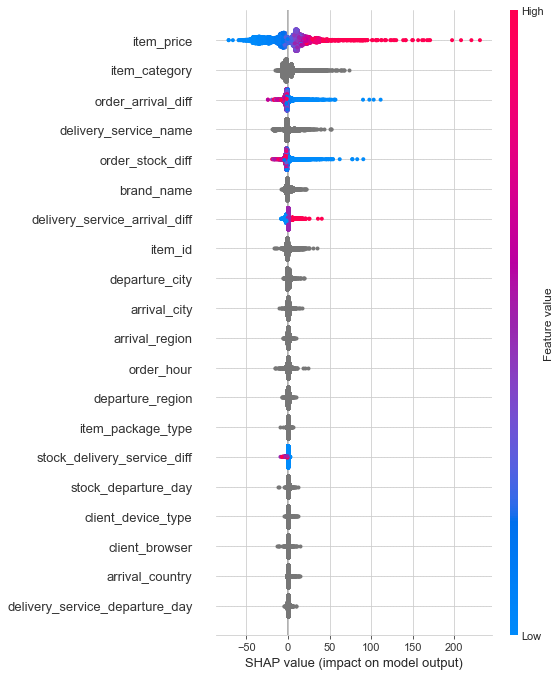

In [93]:
explainer = TreeExplainer(ctb_reg)
shap_values = explainer.shap_values(X_val, y_val)
shap.summary_plot(shap_values, X_val, X_val.columns)

In [94]:
feature_names = X_val.columns
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

shap_importance

,col_name,feature_importance_vals
16,item_price,20.043361
14,item_category,5.042612
18,order_arrival_diff,3.394339
15,delivery_service_name,3.333838
19,order_stock_diff,3.142827
12,brand_name,2.345150
21,delivery_service_arrival_diff,1.967820
13,item_id,1.959212
1,departure_city,1.082999
4,arrival_city,0.701859


In [95]:
shap_importance = shap_importance.reset_index(drop=True)

In [114]:
to_drop = list(shap_importance.loc[11:, 'col_name'])

In [115]:
train_df_drop = train_df.drop(to_drop, axis=1)

In [116]:
cat_features = [i for i in cat_features if i not in to_drop]

In [117]:
train_df_drop[cat_features] = train_df_drop[cat_features].astype(str)
train_df_drop[cat_features] = train_df_drop[cat_features].fillna('None')

In [118]:
y = train_df_drop[target_var]
X = train_df_drop.drop(target_var, axis=1)

In [119]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42)

In [120]:
model_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'iterations': 500, # на 1000 циклах модель переобучается
    'loss_function': 'RMSE'
}

In [121]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

In [122]:
ctb_reg = CatBoostRegressor(**model_params)

In [123]:
ctb_reg.fit(train_pool, eval_set=val_pool, verbose=True, early_stopping_rounds=500)

0:	learn: 51.0325387	test: 52.8702742	best: 52.8702742 (0)	total: 37.1ms	remaining: 18.5s
1:	learn: 48.8703031	test: 50.6168872	best: 50.6168872 (1)	total: 71.4ms	remaining: 17.8s
2:	learn: 46.9890447	test: 48.6551303	best: 48.6551303 (2)	total: 102ms	remaining: 16.9s
3:	learn: 45.3789934	test: 46.9524599	best: 46.9524599 (3)	total: 134ms	remaining: 16.7s
4:	learn: 43.9901614	test: 45.4956849	best: 45.4956849 (4)	total: 156ms	remaining: 15.5s
5:	learn: 42.7565439	test: 44.1176907	best: 44.1176907 (5)	total: 183ms	remaining: 15.1s
6:	learn: 41.6811186	test: 42.8966958	best: 42.8966958 (6)	total: 205ms	remaining: 14.4s
7:	learn: 40.7382015	test: 41.8622902	best: 41.8622902 (7)	total: 233ms	remaining: 14.4s
8:	learn: 39.8944564	test: 40.8760424	best: 40.8760424 (8)	total: 265ms	remaining: 14.4s
9:	learn: 39.1529754	test: 40.0578110	best: 40.0578110 (9)	total: 295ms	remaining: 14.5s
10:	learn: 38.5589964	test: 39.4276076	best: 39.4276076 (10)	total: 324ms	remaining: 14.4s
11:	learn: 38.015

In [124]:
y_pred = ctb_reg.predict(X_val)

In [125]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error (MAE): 12.944141110875094
Mean Squared Error (MSE): 963.13731344087
Root Mean Squared Error (RMSE): 31.034453651399602
R^2 Score: 0.6866024014226375


### Cross val

In [128]:
cv_result = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R^2'])
kf = KFold(n_splits=10, shuffle=False)
kf.get_n_splits(X, y)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    ctb_reg = CatBoostRegressor(**model_params)
    ctb_reg.fit(train_pool, eval_set=val_pool, verbose=False)

    y_pred = ctb_reg.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    cv_result.loc[len(cv_result)] = [mae, mse, rmse, r2]
    print(mae, mse, rmse, r2)

13.167516455518449 969.2121035215732 31.13217151953222 0.6636808972764991
13.384154106791856 1071.1162240845058 32.727912003128246 0.6192137776655724
12.804321771902963 927.1063760069384 30.448421568398885 0.6630592238266534
12.984363756251966 953.5746267803304 30.88000367196109 0.6523991455062579
13.531072350746534 1271.6942673928804 35.660822584355515 0.6183832333027597
12.724355216538308 995.5619578966002 31.55252696530977 0.6331403382441112
13.440814774153385 1169.4316955619042 34.19695447787572 0.6308650319321292
13.123538946836899 1018.5233875135906 31.914313207612516 0.6370705377025951
12.893435749877748 1005.0443919139084 31.702435110160046 0.6583632661809964
12.71913745874753 849.7990227758771 29.151312539504584 0.6842361647489184


In [129]:
cv_result.mean()

MAE       13.077271
MSE     1023.106405
RMSE      31.936687
R^2        0.646041
dtype: float64

In [130]:
ctb_reg.save_model('./model/best_model')